In [141]:
# Notebook to read in the nexus files and only save the useful stuff to slim the files down
import os
import sys
import tables as tb
import numpy  as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import re
from collections import Counter

%matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [142]:
# Load in the hits
hits = pd.read_hdf(f"../data/nexus/1bar/models/xesphere_singleeminus_1_bar_2.5_MeV_low_step.h5", 'hits')
display(hits)

,event_id,x,y,z,time,energy,particle_id,hit_id
0,0,927.907349,-1639.827393,1437.493408,0.000338,0.000066,1,0
1,0,927.914001,-1639.828369,1437.503784,0.000380,0.000005,1,1
2,0,928.021851,-1639.843140,1437.671631,0.001057,0.000022,1,2
3,0,928.164124,-1639.862671,1437.893066,0.001951,0.000301,1,3
4,0,928.272766,-1639.875000,1438.060547,0.002628,0.000039,1,4
...,...,...,...,...,...,...,...,...
80673482,4685,894.639221,-141.786453,-1799.628418,0.473667,0.000288,591,2
80673483,4685,894.641785,-141.784576,-1799.627808,0.473457,0.000151,590,0
80673484,4685,904.463745,-155.291824,-1770.876953,0.337490,0.000316,2,0
80673485,4685,904.468506,-155.294540,-1770.888306,0.337963,0.000523,2,1


In [143]:
event_hits = hits[hits.event_id == 7]
event_hits.z = event_hits.z+5700
event_hits["n"] = round(event_hits["energy"]/25e-6)
display(event_hits)
print(event_hits.energy.sum())
print(0.002081/25e-6)
print(event_hits.n.sum())

/Users/mistryk2/opt/anaconda3/envs/local/lib/python3.10/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_13388/3993377197.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_hits["n"] = round(event_hits["energy"]/25e-6)


,event_id,x,y,z,time,energy,particle_id,hit_id,n
119551,7,-301.292511,-146.777969,5274.340820,0.001615,0.000021,1,0,1.0
119552,7,-301.361603,-146.655594,5274.198242,0.002292,0.000018,1,1,1.0
119553,7,-301.430725,-146.533234,5274.056152,0.002969,0.000063,1,2,3.0
119554,7,-301.465271,-146.472046,5273.984863,0.003307,0.000043,1,3,2.0
119555,7,-301.534363,-146.349686,5273.842773,0.003984,0.000020,1,4,1.0
...,...,...,...,...,...,...,...,...,...
137022,7,-314.292175,-123.297264,5244.684082,0.137936,0.000422,2,1,17.0
137023,7,-314.291809,-123.304535,5244.681641,0.138287,0.000017,2,2,1.0
137024,7,-314.293518,-123.301422,5244.688477,0.138635,0.000760,2,3,30.0
137025,7,-314.296204,-123.301331,5244.689453,0.138846,0.000183,2,4,7.0


2.5
83.24
100281.0


In [144]:
# Create a new DataFrame with duplicated rows, so we can smear each electron by diffusion
new_df = pd.DataFrame(np.repeat(event_hits[["event_id",'x', 'y', 'z']].values, event_hits['n'], axis=0), columns=["event_id",'x', 'y', 'z'])

# Reset the index of the new DataFrame if needed
new_df = new_df.reset_index(drop=True)
display(new_df)

,event_id,x,y,z
0,7.0,-301.292511,-146.777969,5274.340820
1,7.0,-301.361603,-146.655594,5274.198242
2,7.0,-301.430725,-146.533234,5274.056152
3,7.0,-301.430725,-146.533234,5274.056152
4,7.0,-301.430725,-146.533234,5274.056152
...,...,...,...,...
100276,7.0,-314.295349,-123.303154,5244.689941
100277,7.0,-314.295349,-123.303154,5244.689941
100278,7.0,-314.295349,-123.303154,5244.689941
100279,7.0,-314.295349,-123.303154,5244.689941


In [145]:
# Now apply some smearing to each of the electrons
DL = 300e-6 # cm^2 / s
DT = 110e-6 # cm^2 / s

rng = np.random.default_rng()

# Define a function to generate random numbers from Gaussian distribution
def generate_random(row):
    x = row['x'] # mm
    y = row['y'] # mm
    z = row['z'] # since the drift vel is 1mm/us, drift time takes the same value here [mus]
    sigma_DL = np.sqrt(2*DL*abs(z))*10 # mm
    sigma_DT = np.sqrt(2*DT*abs(z))*10 # mm

    xy = (x, y)
    cov_xy = [[sigma_DT, 0], [0, sigma_DT]]
    
    x_smear, y_smear = rng.multivariate_normal(xy, cov_xy, 1).T
    z_smear = np.random.normal(z, sigma_DL)

    return pd.Series([x_smear[0], y_smear[0], z_smear], index=['x_smear', 'y_smear', 'z_smear'])

# Apply the function to create new columns
new_columns = new_df.apply(generate_random, axis=1)
df = pd.concat([new_df, new_columns], axis=1)
df["energy"] = 25e-6 # MeV

display(df)



,event_id,x,y,z,x_smear,y_smear,z_smear,energy
0,7.0,-301.292511,-146.777969,5274.340820,-295.392216,-147.492090,5266.511569,0.000025
1,7.0,-301.361603,-146.655594,5274.198242,-298.202086,-142.072019,5274.166316,0.000025
2,7.0,-301.430725,-146.533234,5274.056152,-306.508172,-146.023353,5274.456276,0.000025
3,7.0,-301.430725,-146.533234,5274.056152,-294.025921,-143.879313,5283.512613,0.000025
4,7.0,-301.430725,-146.533234,5274.056152,-295.636521,-141.399443,5285.207645,0.000025
...,...,...,...,...,...,...,...,...
100276,7.0,-314.295349,-123.303154,5244.689941,-316.385310,-124.037458,5209.220623,0.000025
100277,7.0,-314.295349,-123.303154,5244.689941,-316.272015,-127.918414,5202.257567,0.000025
100278,7.0,-314.295349,-123.303154,5244.689941,-311.331922,-127.640510,5274.018291,0.000025
100279,7.0,-314.295349,-123.303154,5244.689941,-313.721825,-127.051567,5258.569057,0.000025


In [146]:
# now we are going to rebin the data, same bins for z and different sizes for x any y
# Create the bins ---- 
xmin=-5700
xmax=5700
xbw=1

ymin=-5700
ymax=5700
ybw=1

zmin=0
zmax=11400
zbw=15e-3

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

# display(S_electron[ S_electron["eventid"] == 1 ])

# # Now lets bin the data
df['x_smear'] = pd.cut(x=df['x_smear'], bins=xbins,labels=xbin_c, include_lowest=True)
df['y_smear'] = pd.cut(x=df['y_smear'], bins=ybins,labels=ybin_c, include_lowest=True)
df['z_smear'] = pd.cut(x=df['z_smear'], bins=zbins,labels=zbin_c, include_lowest=True)

display(df)

,event_id,x,y,z,x_smear,y_smear,z_smear,energy
0,7.0,-301.292511,-146.777969,5274.340820,-295.5,-147.5,5266.5075,0.000025
1,7.0,-301.361603,-146.655594,5274.198242,-298.5,-142.5,5274.1725,0.000025
2,7.0,-301.430725,-146.533234,5274.056152,-306.5,-146.5,5274.4575,0.000025
3,7.0,-301.430725,-146.533234,5274.056152,-294.5,-143.5,5283.5175,0.000025
4,7.0,-301.430725,-146.533234,5274.056152,-295.5,-141.5,5285.2125,0.000025
...,...,...,...,...,...,...,...,...
100276,7.0,-314.295349,-123.303154,5244.689941,-316.5,-124.5,5209.2225,0.000025
100277,7.0,-314.295349,-123.303154,5244.689941,-316.5,-127.5,5202.2625,0.000025
100278,7.0,-314.295349,-123.303154,5244.689941,-311.5,-127.5,5274.0225,0.000025
100279,7.0,-314.295349,-123.303154,5244.689941,-313.5,-127.5,5258.5725,0.000025


In [147]:
# Merge any duplicate rows and sum their energy
# also rename everything back to normal x,y,z
df = df.drop(columns=['x', 'y', 'z'])
df = df.rename(columns={'x_smear': 'x'})
df = df.rename(columns={'y_smear': 'y'})
df = df.rename(columns={'z_smear': 'z'})

# Create a list of tuples representing each row in the DataFrame
rows_as_tuples = [tuple(row) for row in df.values]

# Use Counter to count the occurrences of each row
row_counts = Counter(rows_as_tuples)

# Map the counts back to the DataFrame
df['duplicates'] = [row_counts[tuple(row)] for row in df.values]

# Multiply 'energy' and 'duplicates' columns
df['energy'] = df['energy'] * df['duplicates']

# Drop the 'duplicates' column
df.drop(columns=['duplicates'], inplace=True)

df = df.drop_duplicates()
display(df)

,event_id,x,y,z,energy
0,7.0,-295.5,-147.5,5266.5075,0.000025
1,7.0,-298.5,-142.5,5274.1725,0.000025
2,7.0,-306.5,-146.5,5274.4575,0.000025
3,7.0,-294.5,-143.5,5283.5175,0.000025
4,7.0,-295.5,-141.5,5285.2125,0.000025
...,...,...,...,...,...
100276,7.0,-316.5,-124.5,5209.2225,0.000025
100277,7.0,-316.5,-127.5,5202.2625,0.000025
100278,7.0,-311.5,-127.5,5274.0225,0.000025
100279,7.0,-313.5,-127.5,5258.5725,0.000025


In [148]:
df = df.sort_values(by=['event_id', 'z', 'x', 'y'])

df['event_id'] = df['event_id'].astype(int)
df['z'] = df['z'].astype('float32')
df['x'] = df['x'].astype('float32')
df['y'] = df['y'].astype('float32')
# df['energy'] = df['energy']*1e6
df['energy'] = df['energy'].astype('float32')

display(df)

with pd.HDFStore(f"../data/nexus/rebinning/test_event.h5", mode='w', complevel=5, complib='zlib') as store:
    # Write each DataFrame to the file with a unique key
    store.put('hits', df, format='table')

,event_id,x,y,z,energy
74961,7,1229.5,356.5,4048.702393,0.000025
75628,7,1222.5,359.5,4051.387451,0.000025
74942,7,1225.5,353.5,4051.612549,0.000025
75470,7,1222.5,358.5,4053.427490,0.000025
75205,7,1233.5,352.5,4054.987549,0.000025
...,...,...,...,...,...
97472,7,-484.5,126.5,5483.332520,0.000025
97430,7,-476.5,123.5,5486.617676,0.000025
97307,7,-484.5,122.5,5489.362305,0.000025
96962,7,-490.5,125.5,5492.752441,0.000025


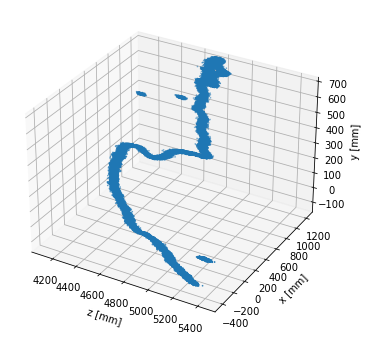

In [149]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('z [mm]')
ax.set_ylabel('x [mm]')
ax.set_zlabel('y [mm]')

x_range = (df.x.max()-df.x.min()) * 0.5
y_range = (df.y.max()-df.y.min()) * 0.5
z_range = (df.z.max()-df.z.min()) * 0.5
mid_x = (df.x.max()+df.x.min()) * 0.5
mid_y = (df.y.max()+df.y.min()) * 0.5
mid_z = (df.z.max()+df.z.min()) * 0.5
ax.set_xlim(mid_z - z_range, mid_z + z_range)
ax.set_ylim(mid_x - x_range, mid_x + x_range)
ax.set_zlim(mid_y - y_range, mid_y + y_range)

# ax.set_xlim(-0.2, 0.2)
# ax.set_ylim(-0.2, 0.2)
# ax.set_zlim(-0.2, 0.2)

fig = plt.gcf()  # Get the current figure
fig.patch.set_facecolor('white')  # Set the background color to white

p = ax.scatter(df.z,df.x,df.y, s=0.5, zorder=2) #coolwarm
ax.scatter(0,0,0,c="red", s=5, zorder=1) #coolwarm
# cb = fig.colorbar(p, ax=ax)
# cb.set_label('Energy [keV]')
# ax.set_title(f"Event: {evt}")
# plt.savefig(f"../plots/events/event_{evt}_P{pressure_v[0]}_E_{energy_v[category]}.png", dpi = 800, transparent=False)

(4040.0, 4140.0)

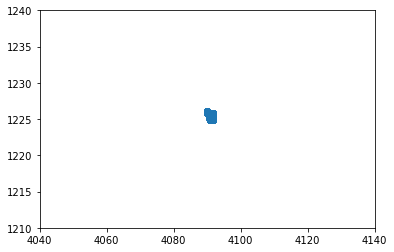

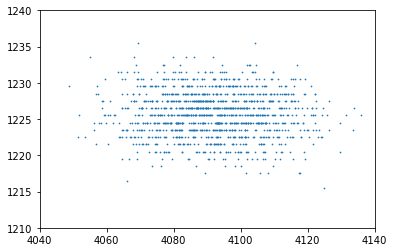

In [150]:
plt.figure()

plt.scatter(new_df.z, new_df.x)
plt.ylim(1210, 1240)
plt.xlim(4040, 4140)

plt.figure()

plt.scatter(df.z, df.x, s=0.5)
plt.ylim(1210, 1240)
plt.xlim(4040, 4140)

,event_id,x,y,z,energy
0,2,840.5,-924.5,5671.117676,0.000025
1,2,848.5,-898.5,5672.812500,0.000025
2,2,809.5,-932.5,5687.212402,0.000025
3,2,851.5,-912.5,5689.282715,0.000025
4,2,810.5,-921.5,5691.727539,0.000025
...,...,...,...,...,...
1600938,20,-321.5,-195.5,8265.442383,0.000025
1600939,20,-39.5,-84.5,8265.547852,0.000025
1600940,20,-319.5,-193.5,8265.592773,0.000025
1600941,20,-3.5,-124.5,8267.362305,0.000025


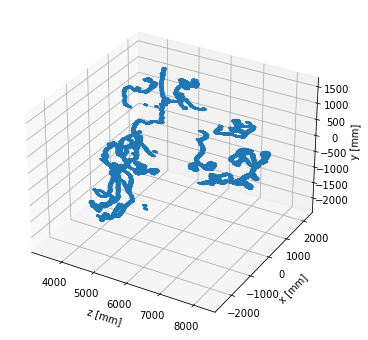

In [155]:
test = pd.read_hdf(f"../data/nexus/rebinning/test_event.h5", 'hits')
display(test)

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('z [mm]')
ax.set_ylabel('x [mm]')
ax.set_zlabel('y [mm]')

fig = plt.gcf()  # Get the current figure
fig.patch.set_facecolor('white')  # Set the background color to white

p = ax.scatter(test.z,test.x,test.y, s=0.5, zorder=2) #coolwarm
